## Задание
1. Выбрать тематику научных публикаций, любую область знаний, например, machine learning или artificial intelligence. 
2. Скачать с https://arxiv.org/ данные о научных публикациях по выбранной тематике. Выгрузить названия, авторов и аннотации статей. Скачивать через api https://info.arxiv.org/help/api/user-manual.html. Не менее 250 публикаций. 
3. Выделить ключевые слова по каждой публикации (используйте названия и аннотации). 
4. Построить связи между ключевыми словами на основе их принадлежности публикациям с использованием библиотек https://networkx.org/, https://graph-tool.skewed.de/static/doc/index.html, https://cosmograph.app/docs/cosmograph/Cosmograph%20Python/configuration/ 
5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.
6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.
7. Построить граф публикаций: если ключевое слово является тегом для двух публикаций, значит, между ними связь есть. Чем больше общих ключевых слов, тем сильнее связь. Реализовать поиск наиболее близких к заданной пользователем публикаций на графе.


In [3]:
!pip install feedparser pandas fastparquet bs4 pypdf2 pdfplumber

In [4]:
import feedparser
import urllib.request as libreq
import feedparser
import re
import time
import pandas as pd
import PyPDF2
import io
from bs4 import BeautifulSoup
import pdfplumber
from concurrent.futures import ThreadPoolExecutor

## №1-2 Скачать данные

In [3]:
CATEGORY = "math.ST"
RESULTS = 250  
BASE_URL = "http://export.arxiv.org/api/query?"
BATCH_SIZE = 10 

In [4]:
def extract_keywords(text):
    """Ищем ключевые слова в тексте."""
    keywords_match = re.search(r'(?i)(?:keywords?|KEYWORDS?):\s*([^\n]+)', text, re.IGNORECASE | re.DOTALL)
    if keywords_match:
        return [kw.strip() for kw in keywords_match.group(1).split(',')]
    return None

def fetch_keywords_from_pdf(pdf_url):
    """Скачиваем PDF, извлекаем текст, ищем Keywords."""
    try:
        with libreq.urlopen(pdf_url) as response:
            pdf_data = response.read()

        with pdfplumber.open(io.BytesIO(pdf_data)) as pdf:
            full_text = "\n".join(page.extract_text() for page in pdf.pages if page.extract_text())

        return extract_keywords(full_text)

    except Exception as e:
        print(f"Ошибка скачивания/парсинга PDF: {e}")
        return None

def fetch_arxiv_papers(category, max_results=RESULTS, batch_size=BATCH_SIZE):
    papers = []

    def process_paper(entry):
        abs_url = entry.id
        pdf_url = abs_url.replace("abs", "pdf")  
        keywords = fetch_keywords_from_pdf(pdf_url) 

        return {
            "title": entry.title,
            "authors": [author.name for author in entry.authors],
            "summary": entry.summary,
            "keywords": keywords
        }

    with ThreadPoolExecutor() as executor:
        for start in range(0, max_results, batch_size):
            query = f"search_query=cat:{category}&start={start}&max_results={batch_size}&sortBy=submittedDate&sortOrder=descending"
            url = BASE_URL + query

            with libreq.urlopen(url) as response:
                data = response.read()

            feed = feedparser.parse(data)

            results = list(executor.map(process_paper, feed.entries))

            papers.extend(results)

            time.sleep(1)  
    
    return papers

In [5]:
papers = fetch_arxiv_papers(CATEGORY)

In [6]:
papers

[{'title': 'Near-Optimal Private Learning in Linear Contextual Bandits',
  'authors': ['Fan Chen',
   'Jiachun Li',
   'Alexander Rakhlin',
   'David Simchi-Levi'],
  'summary': 'We analyze the problem of private learning in generalized linear contextual\nbandits. Our approach is based on a novel method of re-weighted regression,\nyielding an efficient algorithm with regret of order\n$\\sqrt{T}+\\frac{1}{\\alpha}$ and $\\sqrt{T}/\\alpha$ in the joint and local model\nof $\\alpha$-privacy, respectively. Further, we provide near-optimal private\nprocedures that achieve dimension-independent rates in private linear models\nand linear contextual bandits. In particular, our results imply that joint\nprivacy is almost "for free" in all the settings we consider, partially\naddressing the open problem posed by Azize and Basu (2024).',
  'keywords': None},
 {'title': 'Asymptotic Optimism of Random-Design Linear and Kernel Regression Models',
  'authors': ['Hengrui Luo', 'Yunzhang Zhu'],
  'summ

In [7]:
print(f"Всего найдено статей с ключевыми словами: {sum(1 for p in papers if p['keywords'])}")

Всего найдено статей с ключевыми словами: 79


In [8]:
len(papers)

230

In [9]:
df = pd.DataFrame(papers)

In [10]:
df.sample(5)

,title,authors,summary,keywords
64,Revisiting Optimal Proportions for Binary Resp...,"[Lukas Pin, Sofía S. Villar, William F. Rosenb...",This work revisits optimal response-adaptive d...,None
223,Monotone Curve Estimation via Convex Duality,"[Tongseok Lim, Kyeongsik Nam, Jinwon Sohn]",A principal curve serves as a powerful tool fo...,"[Principal Curve, Statistical Error Analysis, ..."
84,Dimension estimation in PCA model using high-d...,"[Una Radojicic, Joni Virta]","We propose a modified, high-dimensional versio...",None
80,Early Stopping for Regression Trees,"[Ratmir Miftachov, Markus Reiß]",We develop early stopping rules for growing re...,None
137,Transfer Learning for Nonparametric Contextual...,"[Fan Wang, Feiyu Jiang, Zifeng Zhao, Yi Yu]",Dynamic pricing strategies are crucial for fir...,None


In [11]:
df.keywords.isna().sum()

np.int64(151)

In [12]:
df.to_parquet('data.parquet.gzip', compression='gzip')

## №3 Выделение ключевых слов

In [3]:
df = pd.read_parquet('data.parquet.gzip')

In [4]:
df.sample(5)

,title,authors,summary,keywords
216,Maximum likelihood estimation in the sparse Ra...,"[Pai Peng, Lianqiang Qu, Qiuping Wang, Shufang...",The Rasch model has been widely used to analys...,[Asymptoticnormality; Consistency; Erdős–Rényi...
0,Near-Optimal Private Learning in Linear Contex...,"[Fan Chen, Jiachun Li, Alexander Rakhlin, Davi...",We analyze the problem of private learning in ...,None
219,Nonparametric estimation of the multivariate S...,"[Ana Pérez, Mercedes Prieto-Alaiz, Fernando Ch...","In this paper, we propose two new estimators o...",[Spearman’s footrule; Multivariate association...
71,Attainability of Two-Point Testing Rates for F...,"[Spencer Compton, Gregory Valiant]",LeCam's two-point testing method yields perhap...,None
52,Fixed-Confidence Best Arm Identification with ...,"[Tamojeet Roychowdhury, Kota Srinivas Reddy, K...",We focus on the problem of best-arm identifica...,None


In [5]:
df.isnull().sum()

title         0
authors       0
summary       0
keywords    151
dtype: int64

In [5]:
!pip install yake networkx matplotlib scipy seaborn textblob stanza

In [6]:
import yake
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import itertools
import seaborn as sns
from textblob import Word
import stanza
import nltk
from nltk.corpus import stopwords

In [8]:
yake_extractor = yake.KeywordExtractor(lan="en", n=4, dedupLim=0.85, top=20)

In [9]:
def extract_keywords(text):
    text = text.lower()
    keywords = yake_extractor.extract_keywords(text)
    return [kw[0] for kw in keywords]

def update_keywords(row):
    existing_keywords = set(row["keywords"]) if isinstance(row["keywords"], list) else set()
    new_keywords = set(extract_keywords(row["title"] + " " + row["summary"]))
    
    updated_keywords = list(existing_keywords | new_keywords) 
    return updated_keywords

In [10]:
df["keywords"] = df.apply(update_keywords, axis=1)

In [11]:
df[['title', 'keywords']].head(5)

,title,keywords
0,Near-Optimal Private Learning in Linear Contex...,"[linear contextual bandits, learning, linear, ..."
1,Asymptotic Optimism of Random-Design Linear an...,"[regression models, linear regression models, ..."
2,A Simplified and Numerically Stable Approach t...,"[simplified and numerically stable, seasonal e..."
3,Simpson's Paradox with Any Given Number of Fac...,"[simpson paradox, number, response variable, f..."
4,Existence of Direct Density Ratio Estimators,"[direct density, two-sample problems call, ave..."


In [12]:
df.iloc[1].keywords

['regression models',
 'linear regression models',
 'models under random designs',
 'scaled asymptotic optimism',
 'closed-form asymptotic optimism',
 'random-design linear',
 'linear regression',
 'derived the closed-form',
 'optimism of random-design linear',
 'asymptotic optimism of random-design',
 'generic predictive model complexity',
 'predictive model complexity measure',
 'model predictive complexity measure',
 'asymptotic optimism',
 'kernel ridge regression',
 'derived the closed-form asymptotic',
 'kernel regression models',
 'closed-form asymptotic',
 'regression',
 'random designs']

In [13]:
stanza.download('en')
nlp = stanza.Pipeline('en')

def lemmatize_keywords_stanza(keywords):
    lemmatized_phrases = []
    
    for phrase in keywords:
        doc = nlp(phrase) 
        lemmatized_words = [word.lemma for word in doc.iter_words()]
        lemmatized_phrases.append(" ".join(lemmatized_words)) 
    
    return lemmatized_phrases

2025-02-26 17:36:49 INFO: Downloaded file to /Users/maksvell/stanza_resources/resources.json
2025-02-26 17:36:49 INFO: Downloading default packages for language: en (English) ...
2025-02-26 17:36:50 INFO: File exists: /Users/maksvell/stanza_resources/en/default.zip
2025-02-26 17:36:51 INFO: Finished downloading models and saved to /Users/maksvell/stanza_resources
2025-02-26 17:36:51 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-26 17:36:51 INFO: Downloaded file to /Users/maksvell/stanza_resources/resources.json
2025-02-26 17:36:52 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2025-02-26 17:36:52 INFO: Using device: cpu
2025-02-26 17:36:52 INFO: Loading: tokenize
2025-02-26 17:36:53 INFO: Loading: mwt
2025-02-26 17:36:53 INFO: Loading: pos
2025-02-26 17:36:54 INFO: Loading: lemma
2025-02-26 17:36:54 INFO: Loading: constituency
2025-02-26 17:36:54 INFO: Loading: depparse
2025-02-26 17:36:54 INFO: Loading: sentiment
2025-02-26 17:36:54 INFO: Loading: ne

In [14]:
df['lemmatized_keywords'] = df['keywords'].apply(lambda row: lemmatize_keywords_stanza(row))

In [15]:
df.head(5)

,title,authors,summary,keywords,lemmatized_keywords
0,Near-Optimal Private Learning in Linear Contex...,"[Fan Chen, Jiachun Li, Alexander Rakhlin, Davi...",We analyze the problem of private learning in ...,"[linear contextual bandits, learning, linear, ...","[linear contextual bandit, learning, linear, l..."
1,Asymptotic Optimism of Random-Design Linear an...,"[Hengrui Luo, Yunzhang Zhu]",We derived the closed-form asymptotic optimism...,"[regression models, linear regression models, ...","[regression model, linear regression model, mo..."
2,A Simplified and Numerically Stable Approach t...,"[Dylan Zammit, Christopher Zerafa]",This study extends the BG/NBD churn probabilit...,"[simplified and numerically stable, seasonal e...","[simplify and numerically stable, seasonal eve..."
3,Simpson's Paradox with Any Given Number of Fac...,"[Guisheng Dai, Weizhen Wang]",Simpson's Paradox is a well-known phenomenon i...,"[simpson paradox, number, response variable, f...","[simpson paradox, number, response variable, f..."
4,Existence of Direct Density Ratio Estimators,"[Erika Banzato, Mathias Drton, Kian Saraf-Poor...",Many two-sample problems call for a comparison...,"[direct density, two-sample problems call, ave...","[direct density, two - sample problem call, av..."


In [16]:
df[['keywords', 'lemmatized_keywords']].iloc[1].values

array([list(['regression models', 'linear regression models', 'models under random designs', 'scaled asymptotic optimism', 'closed-form asymptotic optimism', 'random-design linear', 'linear regression', 'derived the closed-form', 'optimism of random-design linear', 'asymptotic optimism of random-design', 'generic predictive model complexity', 'predictive model complexity measure', 'model predictive complexity measure', 'asymptotic optimism', 'kernel ridge regression', 'derived the closed-form asymptotic', 'kernel regression models', 'closed-form asymptotic', 'regression', 'random designs']),
       list(['regression model', 'linear regression model', 'model under random design', 'scal asymptotic optimism', 'close - form asymptotic optimism', 'random - design linear', 'linear regression', 'derive the close - form', 'optimism of random - design linear', 'asymptotic optimism of random - design', 'generic predictive model complexity', 'predictive model complexity measure', 'model predictiv

In [17]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksvell/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def clean_keywords(keywords):
    cleaned_keywords = []
    
    for phrase in keywords:
        words = phrase.split() 
        filtered_words = [word for word in words if word not in stop_words]
        
        if filtered_words:
            cleaned_keywords.append(" ".join(filtered_words))
    
    return cleaned_keywords

In [19]:
df['cleaned_keywords'] = df['lemmatized_keywords'].apply(clean_keywords)

In [20]:
df.iloc[1].cleaned_keywords

['regression model',
 'linear regression model',
 'model random design',
 'scal asymptotic optimism',
 'close - form asymptotic optimism',
 'random - design linear',
 'linear regression',
 'derive close - form',
 'optimism random - design linear',
 'asymptotic optimism random - design',
 'generic predictive model complexity',
 'predictive model complexity measure',
 'model predictive complexity measure',
 'asymptotic optimism',
 'kernel ridge regression',
 'derive close - form asymptotic',
 'kernel regression model',
 'close - form asymptotic',
 'regression',
 'random design']

In [21]:
df.sample(5)

,title,authors,summary,keywords,lemmatized_keywords,cleaned_keywords
160,Quantifying the Speed-Up from Non-Reversibilit...,"[Gareth O. Roberts, Jeffrey S. Rosenthal]",We investigate the increase in efficiency of s...,"[non-reversible updates to give, simulated and...","[non-reversible update to give, simulate and p...","[non-reversible update give, simulate parallel..."
135,Proportional asymptotics of piecewise exponent...,[Emanuele Massa],We study the flexible piecewise exponential mo...,"[random uncorrelated gaussian, exponential pro...","[random uncorrelate gaussian, exponential prop...","[random uncorrelate gaussian, exponential prop..."
145,Robust Mean Estimation With Auxiliary Samples,"[Barron Han, Danil Akhtiamov, Reza Ghane, Baba...","In data-driven learning and inference tasks, t...","[inference tasks, limited target samples, high...","[inference task, limited target sample, high c...","[inference task, limited target sample, high c..."
83,Statistical guarantees for continuous-time pol...,[Wenlong Mou],We study the estimation of the value function ...,"[statistical guarantees for continuous-time, p...","[statistical guarantee for continuous - time, ...","[statistical guarantee continuous - time, poli..."
93,A fast algorithm to compute a curve of confide...,[Guillermo Durand],This paper presents a new algorithm (and an ad...,"[reference family, forest structure, post hoc ...","[reference family, forest structure, post hoc ...","[reference family, forest structure, post hoc ..."


In [22]:
df.describe()

,title,authors,summary,keywords,lemmatized_keywords,cleaned_keywords
count,230,230,230,230,230,230
unique,230,229,230,230,230,230
top,Near-Optimal Private Learning in Linear Contex...,[Eddy Michel Ella Mintsa],We analyze the problem of private learning in ...,"[linear contextual bandits, learning, linear, ...","[linear contextual bandit, learning, linear, l...","[linear contextual bandit, learning, linear, l..."
freq,1,2,1,1,1,1


In [23]:
all_keywords = [word for keywords in df['cleaned_keywords'] for word in keywords]
keyword_freq = Counter(all_keywords)

most_common_keywords = keyword_freq.most_common(50)
print(most_common_keywords)

[('model', 16), ('distribution', 10), ('learning', 8), ('maximum likelihood', 8), ('time series', 7), ('random', 6), ('time', 6), ('statistical inference', 6), ('datum', 5), ('random variable', 5), ('study problem', 5), ('network', 5), ('process', 5), ('distribution function', 5), ('linear', 4), ('regression', 4), ('gamma', 4), ('diffusion', 4), ('diffusion model', 4), ('causal', 4), ('machine learning', 4), ('graph', 4), ('maximum likelihood estimator', 4), ('order', 4), ('datum science', 4), ('regression model', 3), ('response variable', 3), ('probability distribution', 3), ('transfer learning', 3), ('optimal transport map', 3), ('point', 3), ('function', 3), ('paper investigate', 3), ('linear model', 3), ('central limit theorem', 3), ('problem', 3), ('epsilon', 3), ('estimator', 3), ('estimation', 3), ('test', 3), ('recent year', 3), ('differential privacy', 3), ('stochastic differential', 3), ('stochastic differential equation', 3), ('gradient', 3), ('sample complexity', 3), ('pred

/var/folders/pq/7p0c971j5k7dd6zbzt4kxsj40000gn/T/ipykernel_32381/3615611862.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")


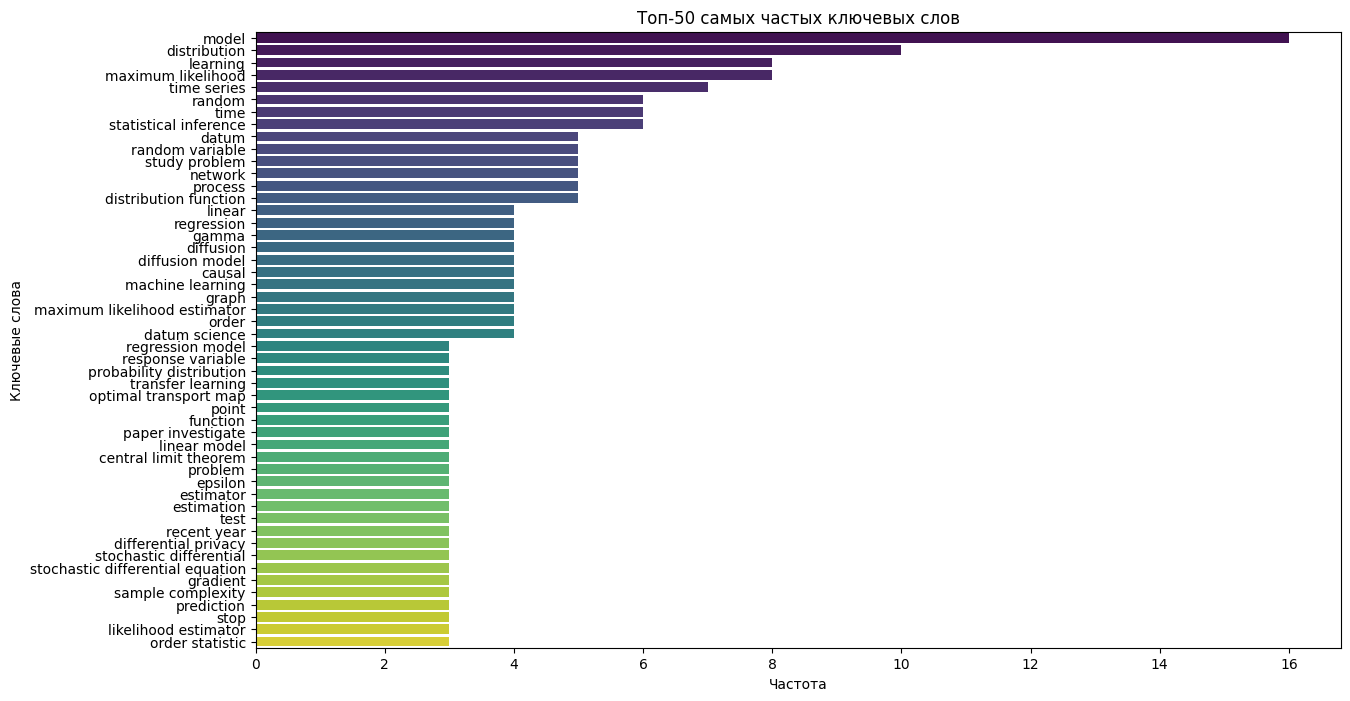

In [24]:
top_keywords = dict(most_common_keywords)
plt.figure(figsize=(14, 8))
sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")
plt.xlabel('Частота')
plt.ylabel('Ключевые слова')
plt.title('Топ-50 самых частых ключевых слов')
plt.show()

In [25]:
!pip install wordcloud

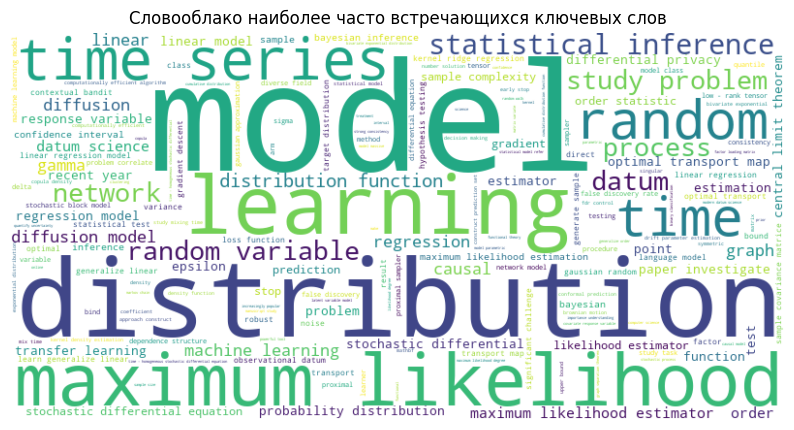

In [27]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Словооблако наиболее часто встречающихся ключевых слов')
plt.show()

In [28]:
unique_keywords = set([word for keywords in df['lemmatized_keywords'] for word in keywords])

print(f"Количество уникальных лемм: {len(unique_keywords)}")

Количество уникальных лемм: 4304


In [29]:
df

,title,authors,summary,keywords,lemmatized_keywords,cleaned_keywords
0,Near-Optimal Private Learning in Linear Contex...,"[Fan Chen, Jiachun Li, Alexander Rakhlin, Davi...",We analyze the problem of private learning in ...,"[linear contextual bandits, learning, linear, ...","[linear contextual bandit, learning, linear, l...","[linear contextual bandit, learning, linear, l..."
1,Asymptotic Optimism of Random-Design Linear an...,"[Hengrui Luo, Yunzhang Zhu]",We derived the closed-form asymptotic optimism...,"[regression models, linear regression models, ...","[regression model, linear regression model, mo...","[regression model, linear regression model, mo..."
2,A Simplified and Numerically Stable Approach t...,"[Dylan Zammit, Christopher Zerafa]",This study extends the BG/NBD churn probabilit...,"[simplified and numerically stable, seasonal e...","[simplify and numerically stable, seasonal eve...","[simplify numerically stable, seasonal event p..."
3,Simpson's Paradox with Any Given Number of Fac...,"[Guisheng Dai, Weizhen Wang]",Simpson's Paradox is a well-known phenomenon i...,"[simpson paradox, number, response variable, f...","[simpson paradox, number, response variable, f...","[simpson paradox, number, response variable, f..."
4,Existence of Direct Density Ratio Estimators,"[Erika Banzato, Mathias Drton, Kian Saraf-Poor...",Many two-sample problems call for a comparison...,"[direct density, two-sample problems call, ave...","[direct density, two - sample problem call, av...","[direct density, two - sample problem call, av..."
...,...,...,...,...,...,...
225,Best-possible bounds on the set of copulas wit...,[Manuel Úbeda-Flores],"In this note, pointwise best-possible (lower a...","[best-possible bounds, lower and upper, set of...","[well - possible bound, low and upper, set of ...","[well - possible bound, low upper, set copula,..."
226,A characterization of uniform distribution usi...,"[Santosh Kumar Chaudhary, Nitin Gupta]","In statistical analysis, quantifying uncertain...","[quantifying uncertainties, distribution, char...","[quantify uncertainty, distribution, character...","[quantify uncertainty, distribution, character..."
227,High-order Accurate Inference on Manifolds,"[Chengzhu Huang, Anru R. Zhang]",We present a new framework for statistical inf...,"[statistical inference, parameter spaces frequ...","[statistical inference, parameter space freque...","[statistical inference, parameter space freque..."
228,Singularities in Bayesian Inference: Crucial o...,"[Maria De Iorio, Andreas Heinecke, Beatrice Fr...","Over the past two decades, shrinkage priors ha...","[shrinkage, crucial or overstated, prior, past...","[shrinkage, crucial or overstate, prior, past ...","[shrinkage, crucial overstate, prior, past two..."


In [30]:
df.to_parquet("preprocessed_data.parquet.gzip", compression='gzip')

## №4 Построение графа связей между ключевыми словами

In [7]:
df = pd.read_parquet("preprocessed_data.parquet.gzip")

In [8]:
!pip install cosmograph

In [9]:
keywords_list = [item for sublist in df['cleaned_keywords'] for item in sublist]
unique_keywords = list(set(keywords_list))

points = pd.DataFrame({
    'id': range(len(unique_keywords)),
    'label': unique_keywords,
    'value': [keywords_list.count(keyword) for keyword in unique_keywords], 
    'category': ['General' for _ in unique_keywords]
})

In [10]:
points

,id,label,value,category
0,0,weight quasi-monte carlo method,1,General
1,1,high - dimensional diffusion statistical infer...,1,General
2,2,difference statistical,1,General
3,3,transport map spherical,1,General
4,4,model - free method event,1,General
...,...,...,...,...
4291,4291,regularize linear regression,1,General
4292,4292,function abrupt,1,General
4293,4293,linear contextual,1,General
4294,4294,high dimensional poisson - laguerre tessellation,1,General


In [11]:
points[['label', 'value']].sort_values(by='value', ascending=False)

,label,value
465,model,16
3095,distribution,10
875,maximum likelihood,8
235,learning,8
4076,time series,7
...,...,...
1472,dimensionality reduction,1
1473,practical success deep,1
1474,berkeley graduate school,1
1475,type I error,1


In [12]:
links_list = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair
        id_1 = points[points['label'] == keyword_1].id.values[0]
        id_2 = points[points['label'] == keyword_2].id.values[0]
        links_list.append({
            'source': id_1,
            'target': id_2,
            'value': 1.0,
        })

In [13]:
links = pd.DataFrame(links_list)

In [14]:
links.shape

(43700, 3)

In [15]:
from cosmograph import cosmo

widget = cosmo(
    points=points,
    links=links,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category', 
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

widget

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [16]:
filtered_points = points[points['value'] > 1]

In [17]:
filtered_points[['label', 'value']].sort_values(by='value', ascending=False)

,label,value
465,model,16
3095,distribution,10
235,learning,8
875,maximum likelihood,8
4076,time series,7
...,...,...
1571,kernel density estimation,2
1581,construct prediction set,2
1661,causal model,2
1707,sample size,2


In [18]:
links_list_1 = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair
        
        if keyword_1 in filtered_points['label'].values and keyword_2 in filtered_points['label'].values:
            id_1 = filtered_points[filtered_points['label'] == keyword_1].id.values[0]
            id_2 = filtered_points[filtered_points['label'] == keyword_2].id.values[0]
            links_list_1.append({
                'source': id_1,
                'target': id_2,
                'value': 1.0,
            })

links_1 = pd.DataFrame(links_list_1)

widget = cosmo(
    points=filtered_points,
    links=links_1,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category', 
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

In [19]:
links_1.shape

(707, 3)

In [20]:
widget

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

## №5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.

In [21]:
!pip install python-louvain

In [22]:
import networkx as nx
import community as community_louvain

In [23]:
G = nx.Graph()

for _, row in filtered_points.iterrows():
    G.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_1.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

In [24]:
G

In [25]:
partition = community_louvain.best_partition(G)

In [27]:
modularity = community_louvain.modularity(partition, G)
print(f"Модулярность: {modularity:.4f}")

Модулярность: 0.6599


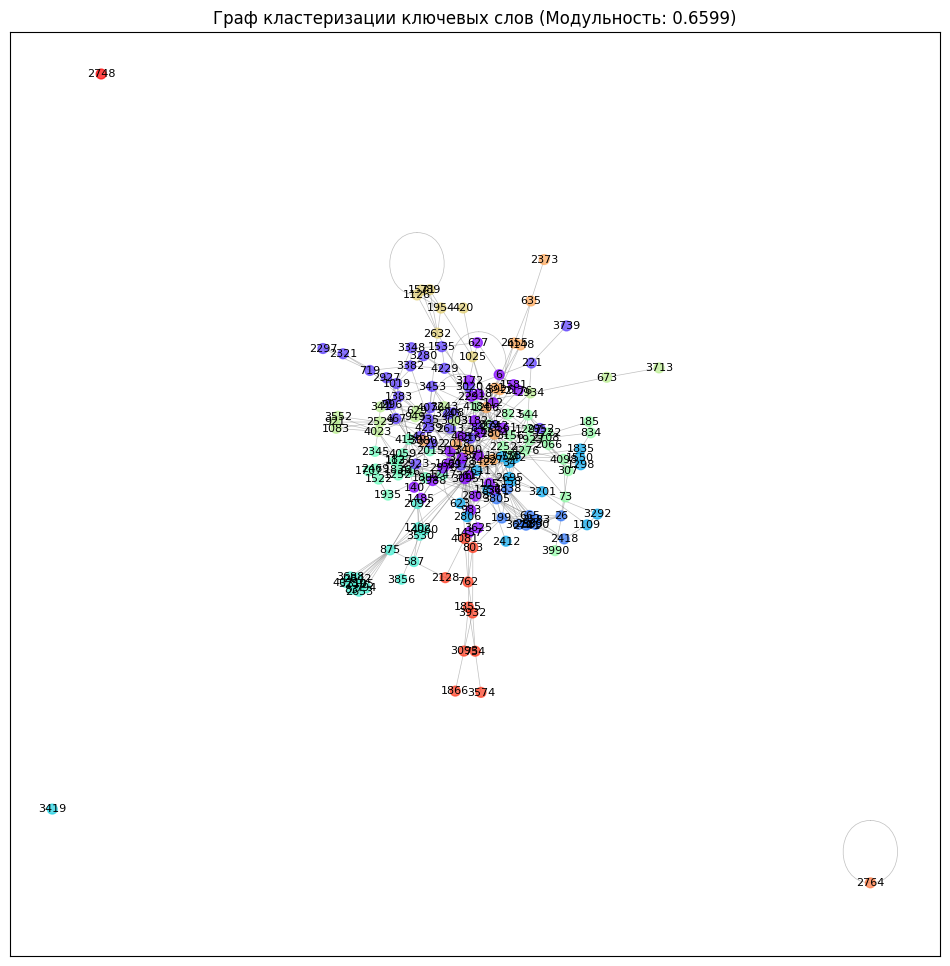

In [30]:
node_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G) 
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Граф кластеризации ключевых слов (Модульность: {modularity:.4f})")
plt.show()

In [31]:
cluster_info = {}
for node, cluster in partition.items():
    cluster_info.setdefault(cluster, []).append(G.nodes[node]['label'])

In [32]:
for cluster, keywords in cluster_info.items():
    print(f"Кластер {cluster}: {', '.join(keywords)}")

Кластер 0: approach construct, testing, machine learning model, graph separation theorem, make, model, manuscript study, prior, increasingly popular, maximum likelihood estimation, construct prediction set, causal model, conformal prediction, class, prediction, bayesian inference, causal, distribution, bind, machine learning, model class, treatment, direct, network model, bayesian, quantile, network, latent variable model
Кластер 1: generalize linear, time, computationally efficient, variable, copula, learning, contextual bandit, online, learn generalize linear, linear model, study task, decision making, gaussian approximation, differential privacy, clustering, arm, sigma, random, dependence structure, learner, gaussian random, study problem, gamma, computationally efficient algorithm, paper investigate, gradient descent, gradient, epsilon, functional theory, time series, central limit theorem, sample complexity
Кластер 2: binary classification, estimation, time - homogeneous stochasti

In [33]:
# Фильтруем кластеры, в которых меньше двух элементов
filtered_cluster_info = {cluster: keywords for cluster, keywords in cluster_info.items() if len(keywords) > 1}

for cluster, keywords in filtered_cluster_info.items():
    print(f"Кластер {cluster}: {', '.join(keywords)}")

Кластер 0: approach construct, testing, machine learning model, graph separation theorem, make, model, manuscript study, prior, increasingly popular, maximum likelihood estimation, construct prediction set, causal model, conformal prediction, class, prediction, bayesian inference, causal, distribution, bind, machine learning, model class, treatment, direct, network model, bayesian, quantile, network, latent variable model
Кластер 1: generalize linear, time, computationally efficient, variable, copula, learning, contextual bandit, online, learn generalize linear, linear model, study task, decision making, gaussian approximation, differential privacy, clustering, arm, sigma, random, dependence structure, learner, gaussian random, study problem, gamma, computationally efficient algorithm, paper investigate, gradient descent, gradient, epsilon, functional theory, time series, central limit theorem, sample complexity
Кластер 2: binary classification, estimation, time - homogeneous stochasti

In [34]:
filtered_points = points[points['label'].isin([keyword for cluster, keywords in filtered_cluster_info.items() if len(keywords) > 1 for keyword in keywords])]

links_list_2 = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair
        
        if keyword_1 in filtered_points['label'].values and keyword_2 in filtered_points['label'].values:
            id_1 = filtered_points[filtered_points['label'] == keyword_1].id.values[0]
            id_2 = filtered_points[filtered_points['label'] == keyword_2].id.values[0]
            links_list_2.append({
                'source': id_1,
                'target': id_2,
                'value': 1.0,
            })
            
links_2 = pd.DataFrame(links_list_2)

widget = cosmo(
    points=filtered_points,
    links=links_2,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category', 
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

widget

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [35]:
G = nx.Graph()

for _, row in filtered_points.iterrows():
    G.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

In [37]:
partition = community_louvain.best_partition(G)

modularity = community_louvain.modularity(partition, G)
print(f"Модулярность: {modularity:.4f}")

Модулярность: 0.6595


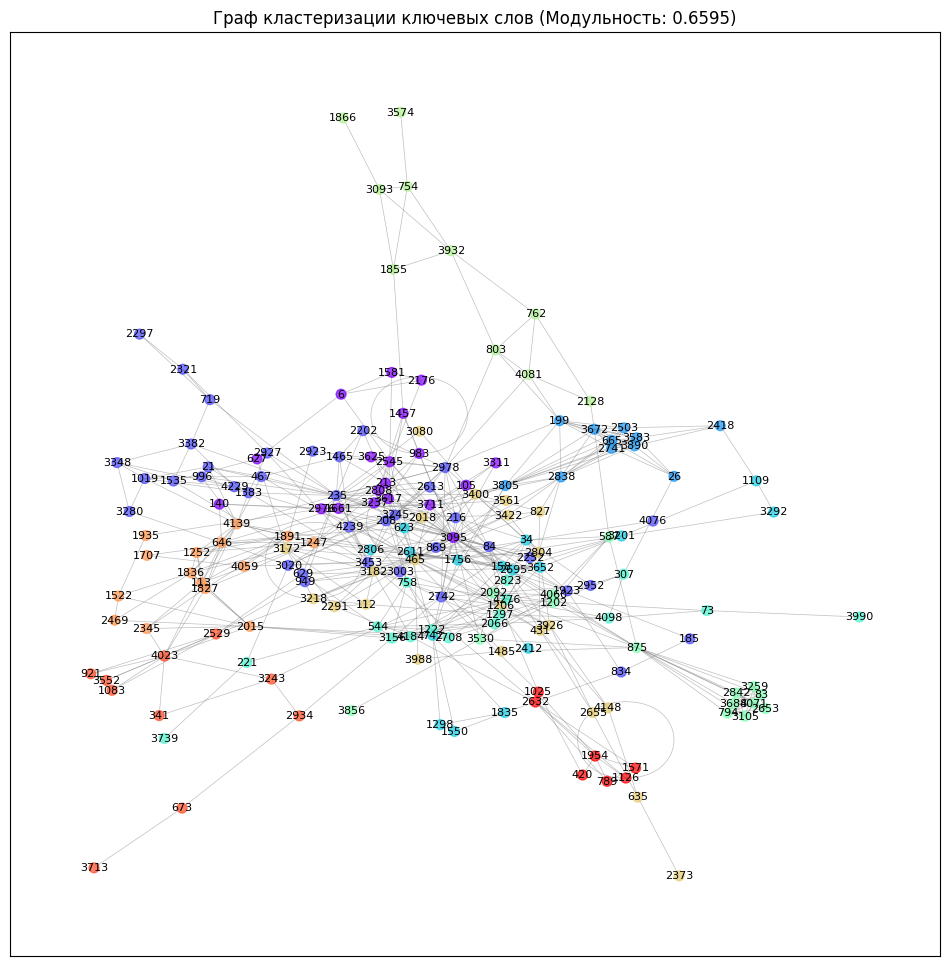

In [38]:
node_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G) 
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Граф кластеризации ключевых слов (Модульность: {modularity:.4f})")
plt.show()

## Оптимизация значения модульности

In [39]:
threshold = 0.8
G_with_threshold = nx.Graph()

for _, row in filtered_points.iterrows():
    G_with_threshold.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    if row['value'] >= threshold: 
        G_with_threshold.add_edge(row['source'], row['target'], weight=row['value'])

In [40]:
partition = community_louvain.best_partition(G)

modularity = community_louvain.modularity(partition, G_with_threshold)
print(f"Модульность: {modularity:.4f}")

Модульность: 0.6598


### SpectralClustering

In [41]:
!pip install scikit-learn

In [42]:
from sklearn.cluster import SpectralClustering

adjacency_matrix = nx.to_numpy_array(G)

clustering = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=42)
labels = clustering.fit_predict(adjacency_matrix)

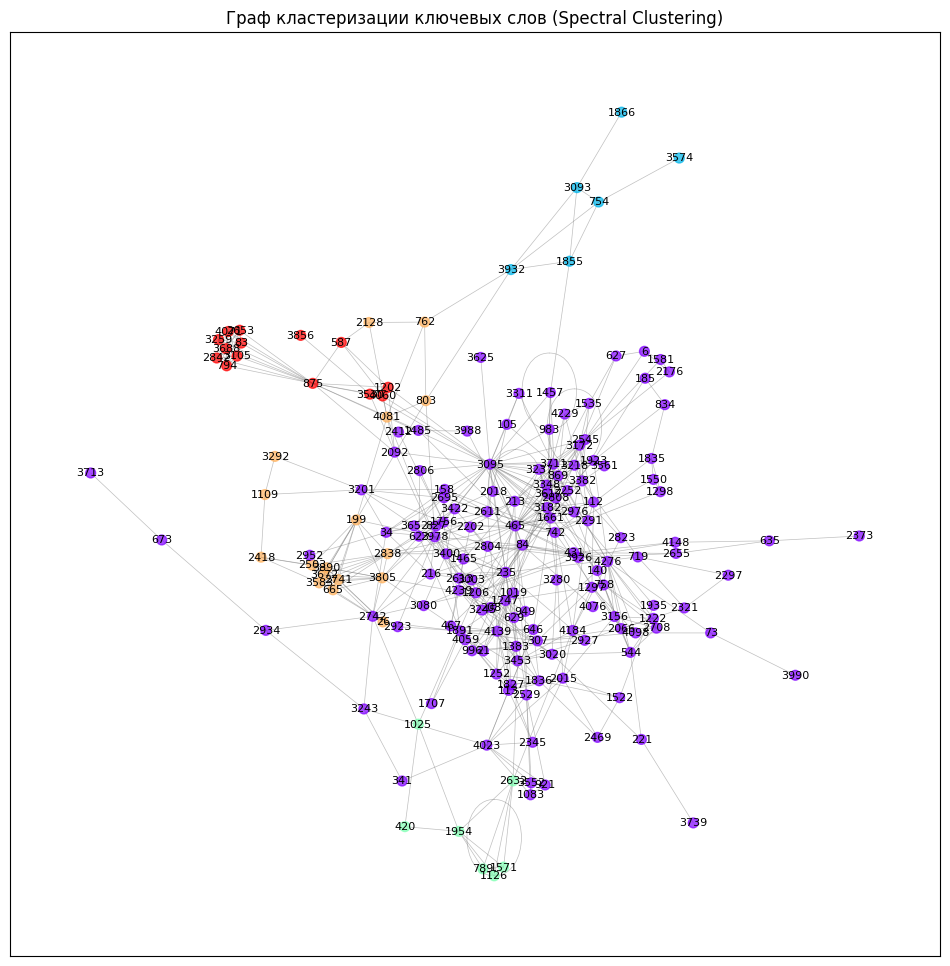

In [43]:
node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title("Граф кластеризации ключевых слов (Spectral Clustering)")
plt.show()

In [44]:
cluster_info = {}
for node, cluster in zip(G.nodes(), labels):
    cluster_info.setdefault(cluster, []).append(G.nodes[node]['label'])

for cluster, keywords in cluster_info.items():
    print(f"Кластер {cluster}: {', '.join(keywords)}")

Кластер 0: approach construct, generalize linear, random variable, factor, time, testing, machine learning model, low - rank tensor, graph separation theorem, cumulative distribution, point, computationally efficient, make, variable, copula, learning, covariate response variable, early stop, study mixing time, model, contextual bandit, bound, importance understanding, manuscript study, parametric, sampler, functional, problem correlate, online, order, optimal, generate sample, function, sample covariance matrice, kernel ridge regression, model parametric, prior, learn generalize linear, linear model, linear regression model, graph, transport, inference, modern datum science, recent year, generalize order, study task, increasingly popular, decision making, maximum likelihood estimation, computer science, gaussian approximation, order statistic, construct prediction set, causal model, sample size, distribution function, tensor, loss function, datum science, statistical inference, singula

In [45]:
node_cluster = {node: label for node, label in zip(G.nodes(), labels)}

m = G.size(weight='weight')

degrees = dict(G.degree(weight='weight'))

Q = 0.0
for u, v, data in G.edges(data=True):
    weight = data['weight'] if 'weight' in data else 1 
    if node_cluster[u] == node_cluster[v]:
        Q += weight - (degrees[u] * degrees[v]) / (2 * m)

Q /= (2 * m)
print(f"Модулярность спектральной кластеризации: {Q:.4f}")

Модулярность спектральной кластеризации: 0.4327


In [46]:
clustering = SpectralClustering(n_clusters=10, affinity='precomputed', random_state=42)
labels = clustering.fit_predict(adjacency_matrix)

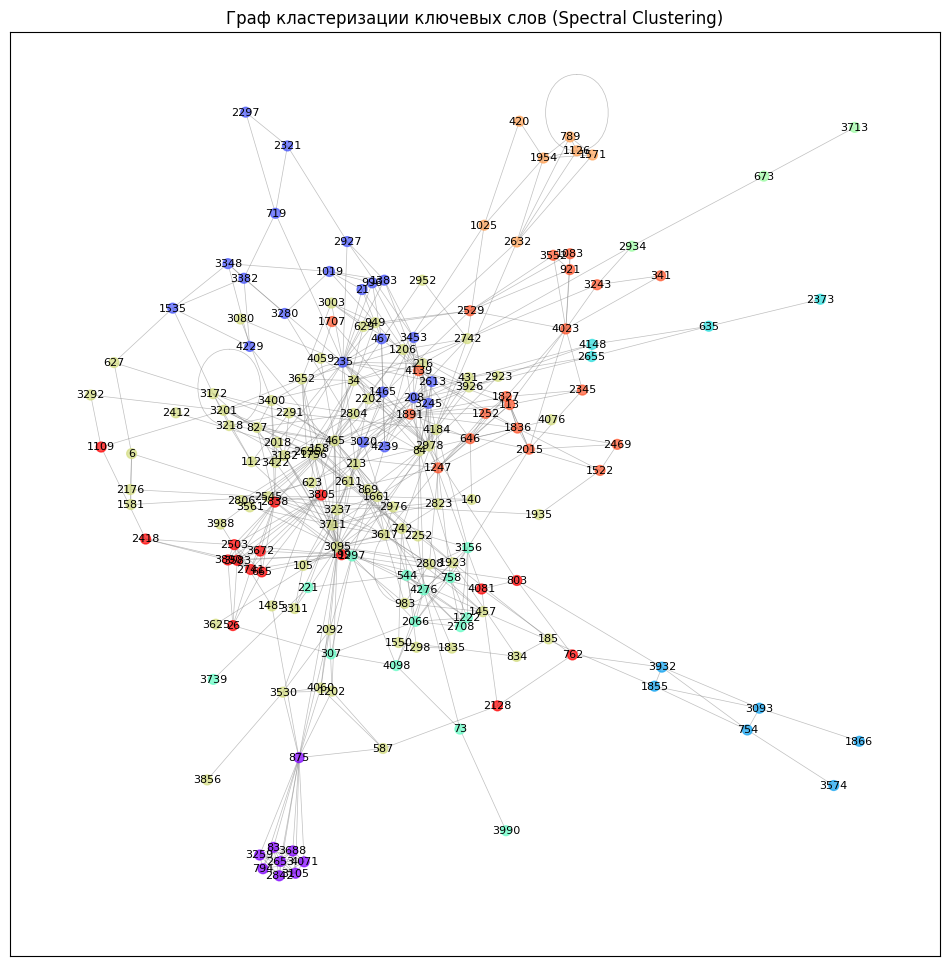

In [47]:
node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title("Граф кластеризации ключевых слов (Spectral Clustering)")
plt.show()

In [49]:
node_cluster = {node: label for node, label in zip(G.nodes(), labels)}

m = G.size(weight='weight')

degrees = dict(G.degree(weight='weight'))

Q = 0.0
for u, v, data in G.edges(data=True):
    weight = data['weight'] if 'weight' in data else 1 
    if node_cluster[u] == node_cluster[v]:
        Q += weight - (degrees[u] * degrees[v]) / (2 * m)

Q /= (2 * m)
print(f"Модулярность спектральной кластеризации: {Q:.4f}")

Модулярность спектральной кластеризации: 0.3757


### DBSCAN

In [50]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [51]:
G_with_all_links = nx.Graph()

for _, row in filtered_points.iterrows():
    G_with_all_links.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    G_with_all_links.add_edge(row['source'], row['target'], weight=row['value'])

In [52]:
adj_matrix = nx.to_numpy_array(G_with_all_links, weight='weight')

cosine_sim = cosine_similarity(adj_matrix)

dist_matrix = 1 - cosine_sim

dist_matrix = np.abs(dist_matrix)

dbscan = DBSCAN(metric="precomputed", eps=0.1, min_samples=5) 
labels = dbscan.fit_predict(dist_matrix)

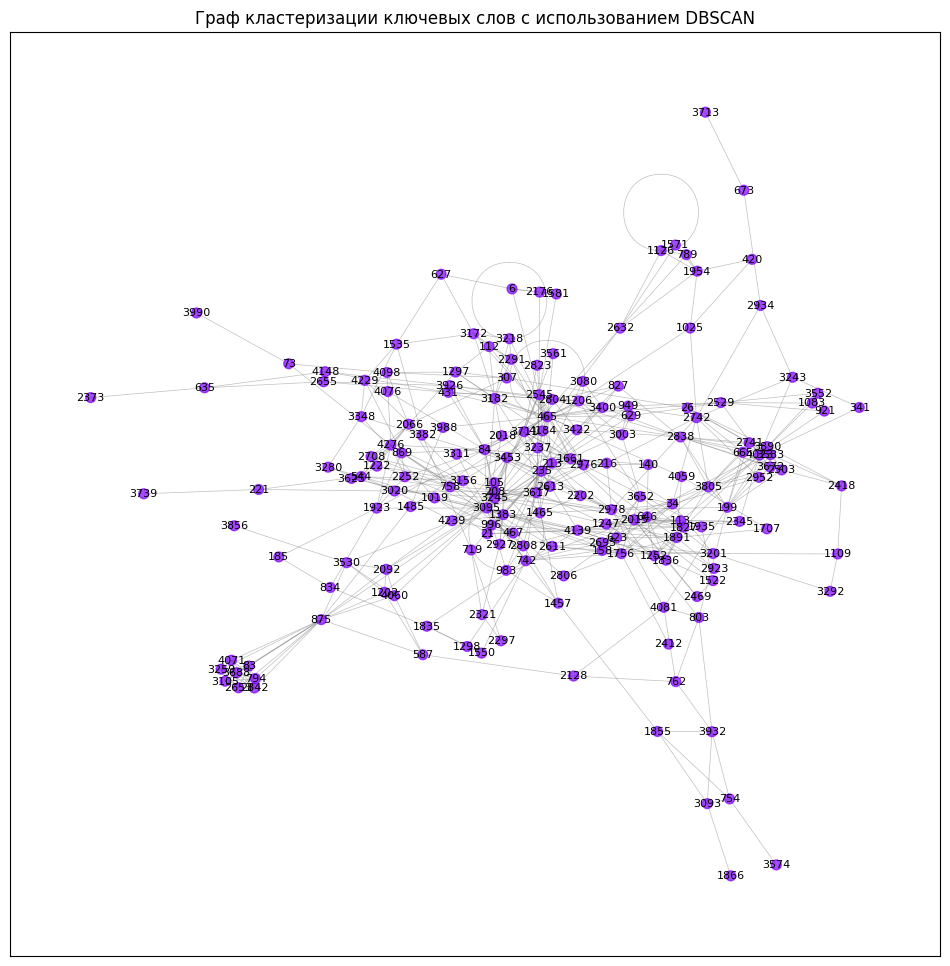

In [53]:
node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_with_all_links)

nx.draw_networkx_nodes(G_with_all_links, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_with_all_links, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_with_all_links, pos, font_size=8, font_color='black')
plt.title("Граф кластеризации ключевых слов с использованием DBSCAN")
plt.show()

In [54]:
cluster_info = {}
for node, cluster in zip(G_with_all_links.nodes(), labels):
    cluster_info.setdefault(cluster, []).append(G_with_all_links.nodes[node]['label'])

In [55]:
for cluster, keywords in cluster_info.items():
    if cluster != -1: 
        print(f"Кластер {cluster}: {', '.join(keywords)}")
    else:
        print(f"Шум: {', '.join(keywords)}")

Шум: approach construct, generalize linear, binary classification, random variable, factor, likelihood degree, time, testing, machine learning model, low - rank tensor, graph separation theorem, cumulative distribution, point, estimation, computationally efficient, make, variable, copula, learning, covariate response variable, early stop, language model, study mixing time, model, contextual bandit, bound, strong consistency, importance understanding, manuscript study, parametric, sampler, functional, time - homogeneous stochastic differential equation, problem correlate, online, order, false discovery rate, optimal, robust, density function, bivariate exponential, variance, generate sample, function, sample covariance matrice, maximum likelihood, kernel ridge regression, model parametric, prior, learn generalize linear, linear model, result, linear regression model, confidence interval, copula density, likelihood estimator, graph, transport, inference, modern datum science, recent year

In [56]:
def modularity(G, partition):
    m = G.size(weight='weight') 
    degrees = dict(G.degree(weight='weight'))
    
    Q = 0.0
    for u, v, data in G.edges(data=True):
        weight = data['weight'] if 'weight' in data else 1  
        if partition[u] == partition[v]:  
            expected_weight = (degrees[u] * degrees[v]) / (2 * m)  
            Q += weight - expected_weight
    
    Q /= (2 * m) 
    return Q

In [57]:
partition = {node: label for node, label in zip(G_with_all_links.nodes(), labels)}

mod = modularity(G_with_all_links, partition)
print(f"Модульность DBSCAN кластеризации: {mod:.4f}")

Модульность DBSCAN кластеризации: 0.4589


## №6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.

### SpectralClustering

In [58]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

In [59]:
degree_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
betweenness_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
eigenvector_sorted = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
closeness_sorted = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

In [60]:
print("Топ 10 ключевых слов по Degree Centrality:")
for node, centrality in degree_sorted[:10]:
    print(f"{G_with_all_links.nodes[node]['label']}: {centrality:.4f}")

print("\nТоп 10 ключевых слов по Betweenness Centrality:")
for node, centrality in betweenness_sorted[:10]:
    print(f"{G_with_all_links.nodes[node]['label']}: {centrality:.4f}")

print("\nТоп 10 ключевых слов по Eigenvector Centrality:")
for node, centrality in eigenvector_sorted[:10]:
    print(f"{G_with_all_links.nodes[node]['label']}: {centrality:.4f}")

print("\nТоп 10 ключевых слов по Closeness Centrality:")
for node, centrality in closeness_sorted[:10]:
    print(f"{G_with_all_links.nodes[node]['label']}: {centrality:.4f}")

Топ 10 ключевых слов по Degree Centrality:
distribution: 0.1966
model: 0.1742
learning: 0.1348
time: 0.0955
maximum likelihood: 0.0843
study problem: 0.0843
distribution function: 0.0787
linear: 0.0787
statistical inference: 0.0730
diffusion: 0.0730

Топ 10 ключевых слов по Betweenness Centrality:
distribution: 0.3077
model: 0.1719
learning: 0.1530
maximum likelihood: 0.0929
time: 0.0926
study problem: 0.0875
probability distribution: 0.0632
random: 0.0606
order: 0.0605
distribution function: 0.0479

Топ 10 ключевых слов по Eigenvector Centrality:
distribution: 0.3814
model: 0.3585
make: 0.2169
bayesian: 0.2156
network: 0.2001
causal model: 0.1914
prediction: 0.1883
causal: 0.1878
time: 0.1830
learning: 0.1829

Топ 10 ключевых слов по Closeness Centrality:
distribution: 0.4373
learning: 0.4073
model: 0.4073
time: 0.4009
make: 0.3828
bayesian: 0.3724
study problem: 0.3708
distribution function: 0.3663
machine learning: 0.3663
order: 0.3611


## №7. Построение графа публикаций

In [61]:
G_publications = nx.Graph()

for idx, row in df.iterrows():
    G_publications.add_node(idx, title=row['title'], authors=row['authors'], summary=row['summary'])

In [62]:
for idx, row in df.iterrows():
    keywords = set(row['cleaned_keywords']) 
    for other_idx, other_row in df.iterrows():
        if idx != other_idx:
            other_keywords = set(other_row['cleaned_keywords'])
            common_keywords = keywords.intersection(other_keywords)
            if common_keywords: 
                weight = len(common_keywords)
                G_publications.add_edge(idx, other_idx, weight=weight)

In [63]:
pagerank = nx.pagerank(G_publications, weight='weight')

sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

In [64]:
print("Топ-5 публикаций по PageRank:")
for idx, score in sorted_pagerank[:5]:
    print(f"Публикация: {df.loc[idx, 'title']}, PageRank: {score:.4f}")

Топ-5 публикаций по PageRank:
Публикация: What is causal about causal models and representations?, PageRank: 0.0220
Публикация: Maximum Likelihood Estimation of the Parameters of Matrix Variate
  Symmetric Laplace Distribution, PageRank: 0.0142
Публикация: Distribution of singular values in large sample cross-covariance
  matrices, PageRank: 0.0137
Публикация: Minimax discrete distribution estimation with self-consumption, PageRank: 0.0136
Публикация: A new class of tests for convex-ordered families based on expected order
  statistics, PageRank: 0.0134


In [65]:
betweenness = nx.betweenness_centrality(G_publications, weight='weight')

sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

In [66]:
print("\nТоп-5 публикаций по Betweenness Centrality:")
for idx, score in sorted_betweenness[:5]:
    print(f"Публикация: {df.loc[idx, 'title']}, Betweenness Centrality: {score:.4f}")


Топ-5 публикаций по Betweenness Centrality:
Публикация: Distribution of singular values in large sample cross-covariance
  matrices, Betweenness Centrality: 0.0987
Публикация: What is causal about causal models and representations?, Betweenness Centrality: 0.0914
Публикация: Maximum Likelihood Estimation of the Parameters of Matrix Variate
  Symmetric Laplace Distribution, Betweenness Centrality: 0.0607
Публикация: Mixing time for a noisy SIS model on graphs, Betweenness Centrality: 0.0597
Публикация: Minimax discrete distribution estimation with self-consumption, Betweenness Centrality: 0.0529


In [67]:
degree_centrality_publications = nx.degree_centrality(G_publications)

sorted_degree = sorted(degree_centrality_publications.items(), key=lambda x: x[1], reverse=True)

In [68]:
print("\nТоп-5 публикаций по Degree Centrality:")
for idx, score in sorted_degree[:5]:
    print(f"Публикация: {df.loc[idx, 'title']}, Degree Centrality: {score:.4f}")


Топ-5 публикаций по Degree Centrality:
Публикация: What is causal about causal models and representations?, Degree Centrality: 0.1354
Публикация: Minimax discrete distribution estimation with self-consumption, Degree Centrality: 0.0873
Публикация: Distribution of singular values in large sample cross-covariance
  matrices, Degree Centrality: 0.0830
Публикация: Mixing time for a noisy SIS model on graphs, Degree Centrality: 0.0830
Публикация: Maximum Likelihood Estimation of the Parameters of Matrix Variate
  Symmetric Laplace Distribution, Degree Centrality: 0.0786


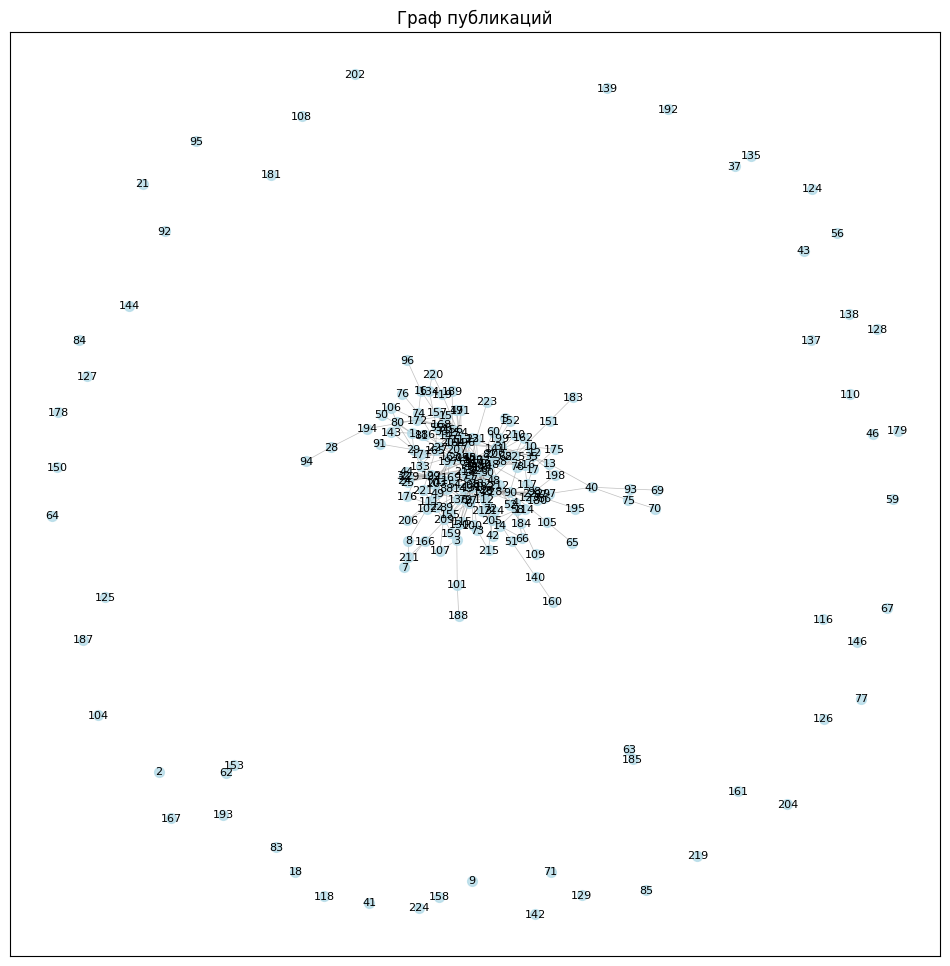

In [69]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_publications, seed=42)
nx.draw_networkx_nodes(G_publications, pos, node_size=50, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_publications, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_publications, pos, font_size=8, font_color='black')
plt.title("Граф публикаций")
plt.show()

In [86]:
df.iloc[98, :].cleaned_keywords

array(['robust label shift', 'shift', 'quantification problem',
       'propose robust estimator', 'quantification', 'maximum likelihood',
       'maximum likelihood label shift', 'label', 'label shift',
       'label shift quantification problem', 'likelihood label shift',
       'shift quantification', 'maximum likelihood estimator',
       'investigate label shift', 'robust label shift quantification',
       'label shift quantification', 'shift quantification problem',
       'maximum likelihood label', 'label distribution turn',
       'robust label'], dtype=object)

In [83]:
target_publication = 98

neighbors = list(G_publications.neighbors(target_publication))
sorted_neighbors = sorted(neighbors, key=lambda x: G_publications[target_publication][x]['weight'], reverse=True)

In [84]:
neighbors

[86, 87, 90, 117, 123, 180, 222]

In [85]:
print(f"\nТоп-5 ближайших публикаций к '{df.loc[target_publication, 'title']}':")
for neighbor in sorted_neighbors[:5]:
    print(f"Публикация: {df.loc[neighbor, 'title']}, Вес связи: {G_publications[target_publication][neighbor]['weight']}")


Топ-5 ближайших публикаций к 'Robust Label Shift Quantification':
Публикация: Maximum Likelihood Estimation of the Parameters of Matrix Variate
  Symmetric Laplace Distribution, Вес связи: 2
Публикация: Score-Preserving Targeted Maximum Likelihood Estimation, Вес связи: 2
Публикация: A Proof of Strong Consistency of Maximum Likelihood Estimator for
  Independent Non-Identically Distributed Data, Вес связи: 2
Публикация: The Maximum Likelihood Degree of Gumbel's Type-I Bivariate Exponential
  Distribution, Вес связи: 1
Публикация: The Maximum Likelihood Degree of Farlie Gumbel Morgenstern Bivariate
  Exponential Distribution, Вес связи: 1
